***
### Библиотеки, служебные функции и переменные

In [1]:
import warnings 
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error

import category_encoders as ce

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from catboost import CatBoostRegressor

In [3]:
random_state = 100
current_year = 2020

In [4]:
# Функция для проверки корреляции.
# Принимает на вход корреляционную матрицу и целевой признак. В качестве доп. параметров есть предел
# по корреляционному коэф-ту 'thresh' и порядок округления 'digits'
# Возвращает датафрейм, где в 1-м столбце - пара коррелирующих признаков со значением корреляции,
# а во 2-м и 3-м - значения корреляции каждого из двух признаков с целевым

def corr_matrix_check(corr_matrix, target, thresh=0.85):
    cols_to_drop_corr = {'pair':[], 'corr_with_target_1':[], 'corr_with_target_2':[]}
    for i, ind in enumerate(corr_matrix.index):
        cols = list(corr_matrix.columns)[i:]
        cols.remove(ind)
        for col in cols:
            corr = abs(corr_matrix.loc[ind, col])
            if corr > thresh:
                cols_to_drop_corr['pair'].append(col + '-' + ind + '=' + str(corr))
                cols_to_drop_corr['corr_with_target_1'].append(col + '=' + str(corr_matrix.loc[col, target]))
                cols_to_drop_corr['corr_with_target_2'].append(ind + '=' + str(corr_matrix.loc[ind, target]))
    return pd.DataFrame.from_dict(cols_to_drop_corr, orient='columns')

***
### Чтение данных

Прочитаем наш датафрейм:

In [5]:
df = pd.read_csv('data/train_data.csv')
df.head()

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    34999 non-null  object 
 2   vehicle_model           34993 non-null  object 
 3   vehicle_category        34999 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    34999 non-null  object 
 7   doors_cnt               34255 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  28282 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

***
### Предобработка данных. Дубликаты и пропуски.

Проверим на дубликаты:

In [7]:
mask = df.duplicated(subset=list(df.columns))
print(f'Число найденных дубликатов: {df[mask].shape[0]}')

Число найденных дубликатов: 0


Посмотрим на пропуски:

In [8]:
df.isna().sum().sort_values(ascending=False)

car_vin                   23512
vehicle_interior_color     6718
doors_cnt                   745
vehicle_color               401
vehicle_model                 7
vehicle_manufacturer          1
vehicle_category              1
vehicle_gearbox_type          1
wheels                        1
row_ID                        0
current_mileage               0
vehicle_year                  0
car_leather_interior          0
deal_type                     0
final_price                   0
dtype: int64

Можно увидеть, что пропуск в признаках ***vehicle_manufacturer***, ***vehicle_category***, ***vehicle_gearbox_type*** и ***wheels*** - это одна единственная запись:

In [9]:
df[df.wheels.isna()]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
17918,17918,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,For Sale,0.0


Удалим её, а также столбец ***row_ID***:

In [10]:
df = df.drop('row_ID', axis=1)
df = df.dropna(subset='wheels')

Поглядим на пропуски ещё раз, теперь в процентах:

In [11]:
df.isna().mean().sort_values(ascending=False) * 100

car_vin                   67.176205
vehicle_interior_color    19.191977
doors_cnt                  2.125775
vehicle_color              1.142890
vehicle_model              0.017143
vehicle_manufacturer       0.000000
vehicle_category           0.000000
current_mileage            0.000000
vehicle_year               0.000000
vehicle_gearbox_type       0.000000
wheels                     0.000000
car_leather_interior       0.000000
deal_type                  0.000000
final_price                0.000000
dtype: float64

Посмотрим на уникальные значения признака ***vehicle_interior_color***:

In [12]:
# уберём ненужные пробелы
df['vehicle_interior_color'] = df['vehicle_interior_color'].str.strip()
df.vehicle_interior_color.unique()

array(['Black', nan, 'Grey', 'Brown', 'Beige', 'Red', 'Yellow', 'White',
       'Orange', 'Blue', 'Golden', 'Carnelian red'], dtype=object)

Упростим категории цвета, а пропускам присвоим значение *Unknown*:

In [13]:
color_dict_interior = {
    'Red':['Red', 'Orange', 'Carnelian red'],
    'Brown':['Brown', 'Beige'],
    'Yellow':['Yellow', 'Golden']
}
for k, v in color_dict_interior.items():
    df['vehicle_interior_color'] = df['vehicle_interior_color'].map(lambda x: k if x in v else x)

df['vehicle_interior_color'] = df['vehicle_interior_color'].fillna('Unknown')

Теперь посмотрим на уникальные значения признака ***vehicle_color***:

In [14]:
# уберём ненужные пробелы
df['vehicle_color'] = df['vehicle_color'].str.strip()
df.vehicle_color.unique()

array(['Silver', 'Blue', 'Black', 'White', 'Grey', 'Red', nan, 'Brown',
       'Green', 'Carnelian red', 'Beige', 'Sky blue', 'Golden', 'Yellow',
       'Purple', 'Orange', 'Pink'], dtype=object)

Упростим категории цвета, а пропускам присвоим значение *Unknown*:

In [15]:
color_dict_vehicle = {
    'Red':['Red', 'Orange', 'Carnelian red'],
    'Blue':['Blue', 'Sky blue'],
    'Brown':['Brown', 'Beige'],
    'Yellow':['Yellow', 'Golden']
}
for k, v in color_dict_vehicle.items():
    df['vehicle_color'] = df['vehicle_color'].map(lambda x: k if x in v else x)

df['vehicle_color'] = df['vehicle_color'].fillna('Unknown')

Теперь разберёмся с количеством дверей. Сделаем так: выясним модели автомобилей, у которых в признаке ***doors_cnt*** пропуски, затем возьмём те же модели из датасета, где количество дверей указано, и подставим на место пропусков:

In [16]:
# сначала переведём названия в нижний регистр
df['vehicle_model'] = df['vehicle_model'].str.lower()

# выясняем модели авто, у которых не указано количество дверей
mask = df['doors_cnt'].isna()

models_to_fix = df.loc[mask, 'vehicle_model'].unique()

models_dict = {}
for model in models_to_fix:    
    mask_ = df['vehicle_model'] == model
    if df.loc[mask_, 'doors_cnt'].nunique() != 0:
        # возьмем количество дверей у самой распространенной модели
        models_dict[model] = df.loc[mask_, 'doors_cnt'].value_counts().sort_values(ascending=False).index[0]
    else:
        # если модель единственная, берём модальным значение
        models_dict[model] = df['doors_cnt'].mode()[0]

# заполним пропуски
df.loc[mask, 'doors_cnt'] = df.loc[mask, 'vehicle_model'].map(models_dict)

Теперь разберёмся с пропусками в признаке ***vehicle_model*** (их всего 6):

In [17]:
df[df.vehicle_model.isna()]

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
6300,სხვა,NaN,Universal,0,2007,Tiptronic,2/3,Left wheel,Blue,Black,NaN,1,For Sale,2500.0
11796,HONDA,NaN,Hatchback,168900,2012,Automatic,4/5,Right-hand drive,White,Black,NaN,1,For Sale,4200.0
14755,სხვა,NaN,Limousine,400,2019,Automatic,>5,Left wheel,White,Black,NaN,1,For Sale,14500.0
20642,JAC,NaN,Microbus,1000,2019,Manual,4/5,Left wheel,White,Grey,NaN,1,For Sale,22500.0
22563,სხვა,NaN,Sedan,32895,1972,Manual,4/5,Left wheel,Green,Brown,NaN,0,For Sale,1.0
32928,FOTON,NaN,Sedan,100000,2001,Manual,4/5,Left wheel,Green,Yellow,NaN,0,For Sale,223.0


Учитывая, какие характеристики у нас в признаках, мы не можем однозначно определить модель, тем более что признак ***VIN*** здесь пропущен.

Давайте заполним пропуски модальным значением для каждого конкретного производителя:

In [18]:
manufacturer_list = df.loc[df.vehicle_model.isna(), 'vehicle_manufacturer'].unique().tolist()

for manufacturer in manufacturer_list:
    mask_ = df.vehicle_manufacturer == manufacturer
    # сделаем через try-except, поскольку не у всех есть модальное значение
    try:
        mode_ = df.loc[mask_, 'vehicle_model'].mode()[0]
    except:
        mode_ = 'unknown'
    df.loc[mask_, 'vehicle_model'] = df.loc[mask_, 'vehicle_model'].fillna(mode_)

Теперь разберёмся с признаком ***car_vin***. Поскольку там около 2/3 пропусков, удалим его:

In [19]:
df = df.drop('car_vin', axis=1)

***
### Разведочный анализ данных.

Посмотрим ещё раз на наш датасет:

In [20]:
df.head(10)

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type,final_price
0,TOYOTA,aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,0,For Sale,3650.0
1,MERCEDES-BENZ,c 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,0,For Sale,6800.0
2,HYUNDAI,veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,1,For Sale,6300.0
3,HYUNDAI,santa fe,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,1,For Sale,14488.0
4,TOYOTA,chr,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,Unknown,1,For Sale,5000.0
5,MITSUBISHI,delica,Jeep,149000,2003,Automatic,4/5,Right-hand drive,Silver,Black,0,For Sale,20.0
6,HYUNDAI,tucson,Jeep,173600,2013,Automatic,4/5,Left wheel,Silver,Black,1,For Sale,7632.0
7,BMW,x5,Jeep,264000,2006,Tiptronic,4/5,Left wheel,Silver,Black,1,For Sale,6500.0
8,TOYOTA,aqua,Hatchback,86658,2017,Automatic,4/5,Left wheel,White,Black,1,For Sale,4870.0
9,BMW,640,Sedan,190000,2012,Tiptronic,4/5,Left wheel,Grey,Black,1,For Sale,16500.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34999 entries, 0 to 34999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   vehicle_manufacturer    34999 non-null  object 
 1   vehicle_model           34999 non-null  object 
 2   vehicle_category        34999 non-null  object 
 3   current_mileage         34999 non-null  int64  
 4   vehicle_year            34999 non-null  int64  
 5   vehicle_gearbox_type    34999 non-null  object 
 6   doors_cnt               34999 non-null  object 
 7   wheels                  34999 non-null  object 
 8   vehicle_color           34999 non-null  object 
 9   vehicle_interior_color  34999 non-null  object 
 10  car_leather_interior    34999 non-null  int64  
 11  deal_type               34999 non-null  object 
 12  final_price             34999 non-null  float64
dtypes: float64(1), int64(3), object(9)
memory usage: 3.7+ MB


Сначала посмотрим на признак ***deal_type***:

In [22]:
df.deal_type.unique()

array(['For Sale', 'For Rent'], dtype=object)

Ага, тут не только продажа машин, но и аренда. Посмотрим на соотношение:

In [23]:
df.deal_type.value_counts(normalize=True) * 100

For Sale    98.205663
For Rent     1.794337
Name: deal_type, dtype: float64

Сделок аренды всего около 2% от общего количества, но даже в этом случае присутствие в датасете и аренды, и продажи может сильно исказить результат. Очевидно, что ценообразование в этих случаях совершенно разное, поэтому нам нужно будет построить две модели - одну для продаж, другую - для аренды.

Разделим датасет на 2 части:

In [24]:
df_sale = df[df.deal_type == 'For Sale']
df_rent = df[df.deal_type == 'For Rent']

Построим график зависимости цены продажи от различных категорий. Довольно очевидно, что будет однозначная зависимость от марки, модели, пробега и года выпуска. Проверим остальные признаки.

Сначала посмотрим на типа авто:

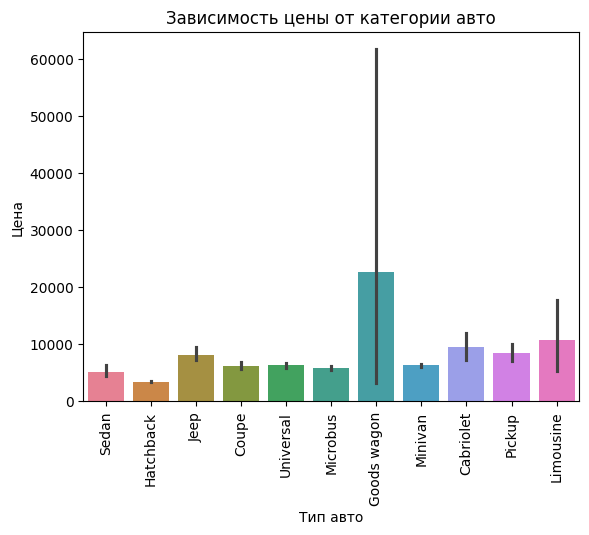

In [25]:
sns.barplot(x=df_sale.vehicle_category, y=df_sale.final_price, hue=df_sale.vehicle_category)

plt.title('Зависимость цены от категории авто')
plt.xlabel('Тип авто')
plt.ylabel('Цена')
plt.xticks(rotation=90);

Зависимость есть, что в общем-то и ожидалось.

Зависимость цены от типа коробки передач:

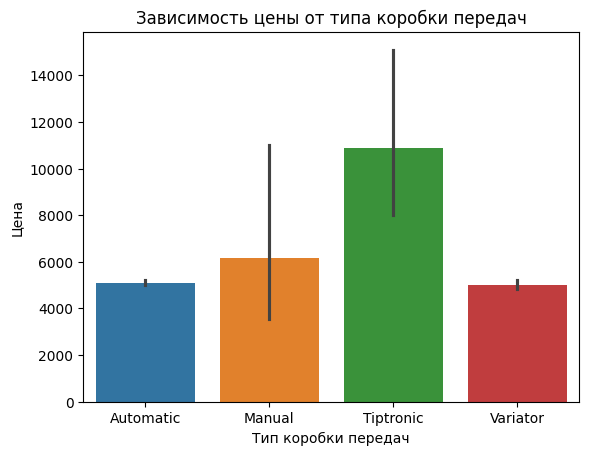

In [26]:
sns.barplot(x=df_sale.vehicle_gearbox_type, y=df_sale.final_price, hue=df_sale.vehicle_gearbox_type)

plt.title('Зависимость цены от типа коробки передач')
plt.xlabel('Тип коробки передач')
plt.ylabel('Цена');

In [27]:
df_sale.vehicle_gearbox_type.value_counts(normalize=True) * 100

Automatic    69.421896
Tiptronic    15.862209
Manual       10.782346
Variator      3.933549
Name: vehicle_gearbox_type, dtype: float64

Зависимость цены от количества дверей:

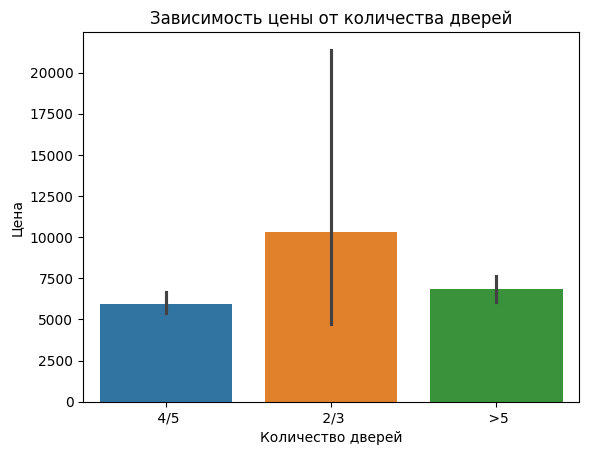

In [28]:
sns.barplot(x=df_sale.doors_cnt, y=df_sale.final_price, hue=df_sale.doors_cnt)

plt.title('Зависимость цены от количества дверей')
plt.xlabel('Количество дверей')
plt.ylabel('Цена');

In [29]:
df_sale.doors_cnt.value_counts(normalize=True) * 100

 4/5    94.600099
 2/3     4.599808
 >5      0.800093
Name: doors_cnt, dtype: float64

Зависимость цены от расположения руля:

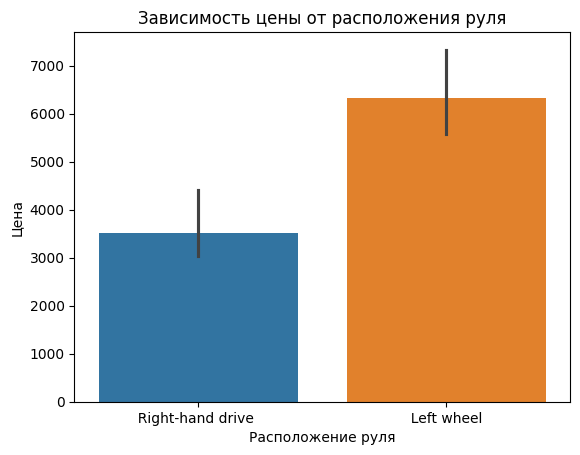

In [30]:
sns.barplot(x=df_sale.wheels, y=df_sale.final_price, hue=df_sale.wheels)

plt.title('Зависимость цены от расположения руля')
plt.xlabel('Расположение руля')
plt.ylabel('Цена');

Зависимость от цвета авто и салона:

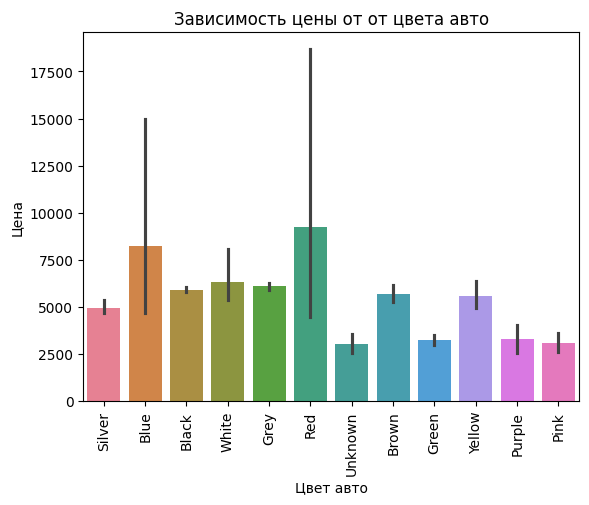

In [31]:
sns.barplot(x=df_sale.vehicle_color, y=df_sale.final_price, hue=df_sale.vehicle_color)

plt.title('Зависимость цены от от цвета авто')
plt.xlabel('Цвет авто')
plt.ylabel('Цена')
plt.xticks(rotation=90);

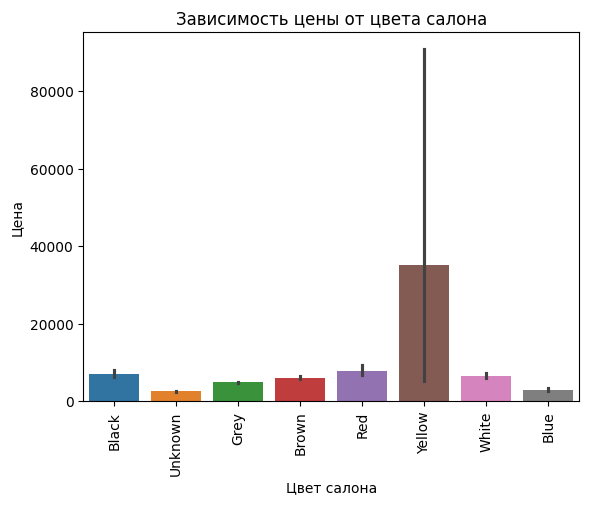

In [32]:
sns.barplot(x=df_sale.vehicle_interior_color, y=df_sale.final_price, hue=df_sale.vehicle_interior_color)

plt.title('Зависимость цены от цвета салона')
plt.xlabel('Цвет салона')
plt.ylabel('Цена')
plt.xticks(rotation=90);

Ну и напоследок посмотрим на признак ***car_leather_interior***:

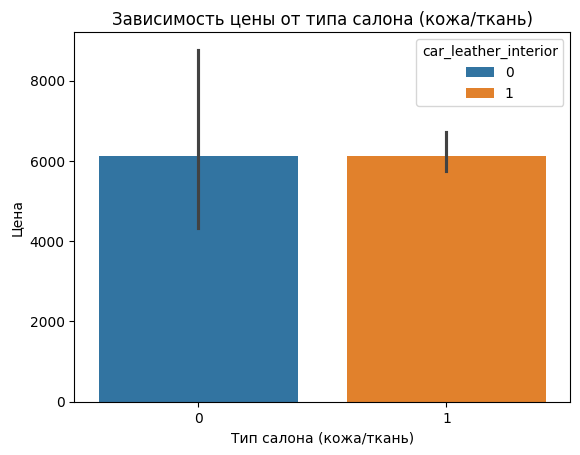

In [33]:
sns.barplot(x=df_sale.car_leather_interior, y=df_sale.final_price, hue=df_sale.car_leather_interior)

plt.title('Зависимость цены от типа салона (кожа/ткань)')
plt.xlabel('Тип салона (кожа/ткань)')
plt.ylabel('Цена');

Разделим признаки на категориальные и численные:

In [34]:
types = df_sale.dtypes
cat_features = list(types[(types == 'object')].index)
num_features = list(types[(types != 'object')].index)
print(len(cat_features), cat_features)
print(len(num_features), num_features)

9 ['vehicle_manufacturer', 'vehicle_model', 'vehicle_category', 'vehicle_gearbox_type', 'doors_cnt', 'wheels', 'vehicle_color', 'vehicle_interior_color', 'deal_type']
4 ['current_mileage', 'vehicle_year', 'car_leather_interior', 'final_price']


Посмотрим на числовые признаки:

In [35]:
df_sale[num_features].describe()

,current_mileage,vehicle_year,car_leather_interior,final_price
count,3.437100e+04,34371.000000,34371.000000,3.437100e+04
mean,1.907441e+06,2010.765762,0.722470,6.119873e+03
std,5.584141e+07,5.827576,0.447787,7.407947e+04
min,0.000000e+00,1940.000000,0.000000,0.000000e+00
25%,7.149900e+04,2009.000000,0.000000,1.500000e+03
50%,1.290000e+05,2012.000000,1.000000,4.000000e+03
75%,1.905555e+05,2014.000000,1.000000,7.000000e+03
max,2.147484e+09,2020.000000,1.000000,8.388607e+06


Построим коробчатые диаграммы для числовых признаков:

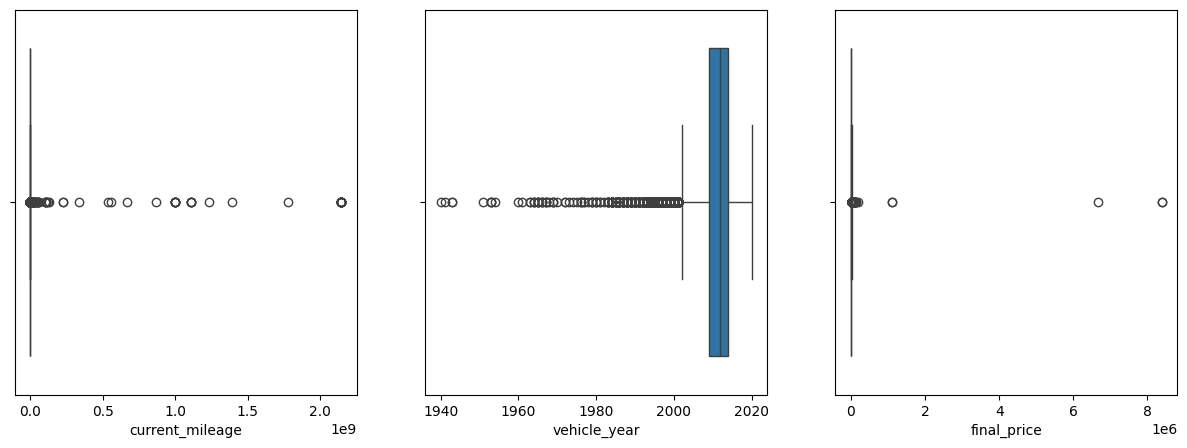

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.boxplot(ax=axes[0], x=df_sale['current_mileage'])
sns.boxplot(ax=axes[1], x=df_sale['vehicle_year'])
sns.boxplot(ax=axes[2], x=df_sale['final_price']);

Видим довольно большое число выбросов.

Давайте начнём с цены. Посмотрим на автомобили с ценой выше 100К:

In [37]:
df_sale[df_sale['final_price'] > 1e+5]

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type,final_price
3877,VOLKSWAGEN,golf,Sedan,7676,2007,Tiptronic,4/5,Left wheel,Red,Yellow,0,For Sale,8388607.0
12136,BMW,328,Sedan,246000,2008,Automatic,4/5,Left wheel,Blue,Yellow,1,For Sale,1111111.0
15291,MERCEDES-BENZ,g 65 amg 63amg,Jeep,0,2020,Tiptronic,4/5,Left wheel,Black,Brown,1,For Sale,200000.0
19820,PORSCHE,panamera turbo s e-hyb,Sedan,16000,2017,Tiptronic,4/5,Left wheel,Red,White,1,For Sale,135000.0
20577,BMW,520,Sedan,536688566,1992,Manual,4/5,Left wheel,Grey,Black,1,For Sale,111111.0
24980,SUBARU,legacy,Sedan,97000,2003,Manual,4/5,Right-hand drive,Silver,Black,1,For Sale,1111111.0
32442,OPEL,combo,Goods wagon,99999,1999,Manual,2/3,Left wheel,Blue,Black,0,For Sale,8388607.0
32937,LAMBORGHINI,gallardo,Coupe,26000,2013,Tiptronic,2/3,Left wheel,Yellow,Black,1,For Sale,135000.0
34052,MERCEDES-BENZ,ml 320,Jeep,111111111,2002,Tiptronic,4/5,Left wheel,White,Black,1,For Sale,6666666.0


Таких машин очень мало. Если цена на Ламборджини или Мерседес выглядит более-менее адекватно, то цена больше 8М за Гольф нереальна.

Уберём цены выше 200К:

In [38]:
df = df[df['final_price'] <= 2e+5]

Посмтрим на нулевые цены:

In [39]:
df_sale[df_sale['final_price'] == 0]

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type,final_price
7123,CHEVROLET,lacetti,Hatchback,200000,2006,Manual,4/5,Left wheel,Black,Grey,0,For Sale,0.0


Машину не могут отдавать бесплатно, поэтому удалим эту запись:

In [40]:
df = df[df['final_price'] != 0]

Теперь разберёмся с пробегом:

In [41]:
df[df['current_mileage'] > 1e+6]

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type,final_price
316,SUZUKI,grand vitara,Jeep,2147483647,1999,Manual,4/5,Left wheel,Red,Black,1,For Rent,2073.0
358,MERCEDES-BENZ,e 200,Sedan,2844468,2001,Manual,4/5,Left wheel,Blue,Black,0,For Sale,3500.0
613,SUBARU,legacy,Universal,1980000,2005,Tiptronic,4/5,Right-hand drive,Black,Black,0,For Sale,2200.0
660,MITSUBISHI,pajero,Jeep,1111111,1996,Automatic,4/5,Left wheel,Yellow,Brown,0,For Sale,2000.0
824,SUZUKI,swift,Hatchback,23000000,2005,Manual,4/5,Right-hand drive,Silver,Brown,0,For Sale,733.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34026,HYUNDAI,elantra,Sedan,1624000,2016,Tiptronic,4/5,Left wheel,White,Grey,0,For Sale,8500.0
34230,OPEL,astra,Sedan,111111111,1999,Manual,4/5,Left wheel,Silver,White,0,For Sale,1700.0
34360,FORD,transit,Microbus,1111111,2000,Manual,2/3,Left wheel,White,Grey,0,For Sale,4100.0
34791,MERCEDES-BENZ,200,Sedan,3000000,1998,Manual,4/5,Left wheel,Green,Black,0,For Sale,2000.0


А давайте узнаем, каков максимальный пробег вообще, например [тут](https://www.autonews.ru/news/5c90b9b89a7947222d28e4f8). Таким образом, можно ограничить пробег 3 млн. миль:

In [42]:
df = df[df['current_mileage'] <= 3e+6]

Признак ***vehicle_year*** (год выпуска) выглядит более-менее нормально.

Посмотрим ещё раз на коробчатые диаграммы:

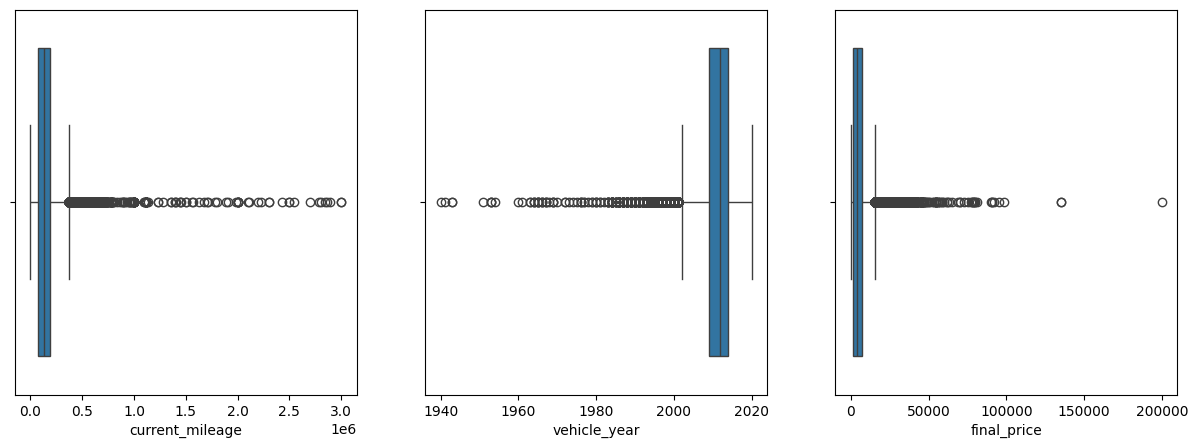

In [43]:
df_sale = df[df.deal_type == 'For Sale']
df_rent = df[df.deal_type == 'For Rent']

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
sns.boxplot(ax=axes[0], x=df_sale['current_mileage'])
sns.boxplot(ax=axes[1], x=df_sale['vehicle_year'])
sns.boxplot(ax=axes[2], x=df_sale['final_price']);

Выглядит уже заметно лучше. Посмотрим на диаграммы рассеяния:

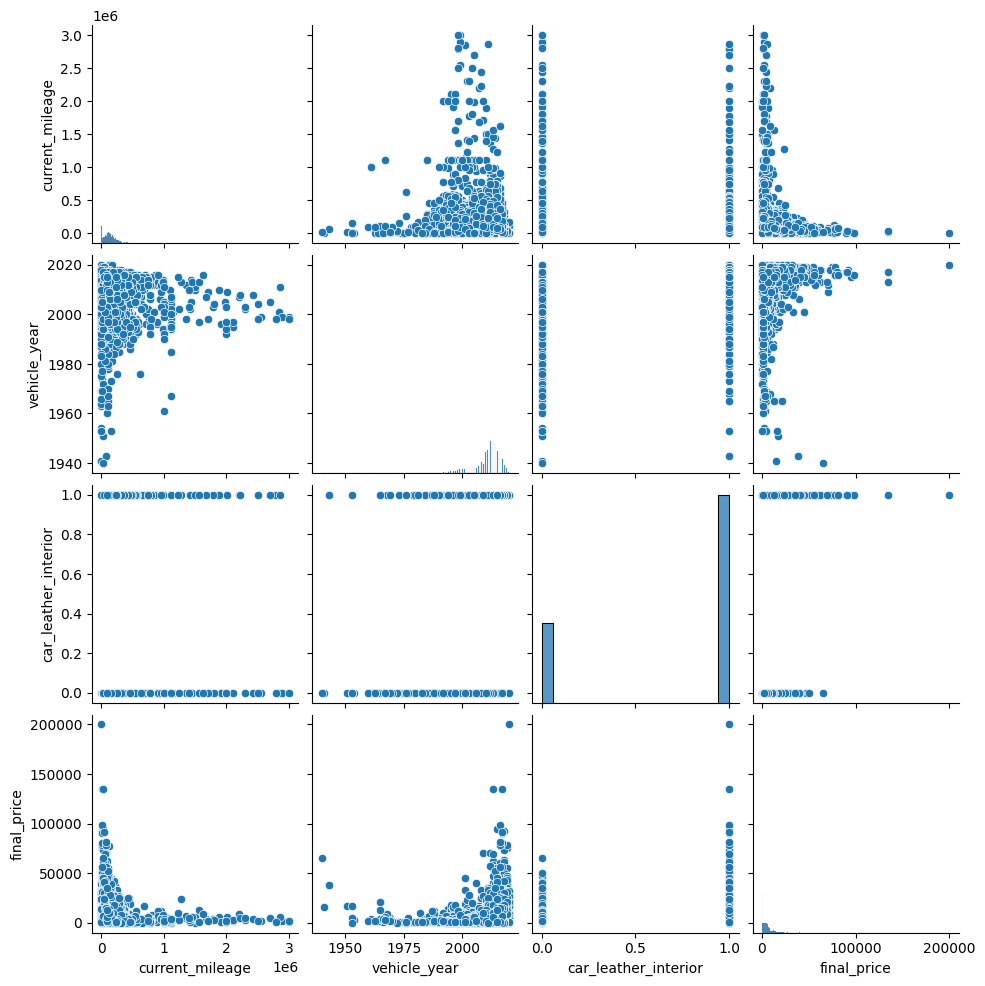

In [44]:
sns.pairplot(df_sale[num_features]);

In [45]:
df_sale[df_sale['vehicle_year'] < 1950]

,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_leather_interior,deal_type,final_price
2529,MERCEDES-BENZ,230 w153,Sedan,69000,1943,Automatic,4/5,Left wheel,White,Red,1,For Sale,38000.0
9287,GAZ,21,Sedan,1234,1941,Manual,2/3,Left wheel,Brown,Black,0,For Sale,15500.0
21930,MERCEDES-BENZ,220 w153,Limousine,69000,1943,Automatic,4/5,Left wheel,White,Red,1,For Sale,38000.0
30042,CADILLAC,escalade,Sedan,21000,1940,Manual,4/5,Left wheel,Black,Black,0,For Sale,65000.0


Давайте всё-таки удалим значения, похожие на выбросы:
- три записи, где цена больше 100К;
- четыре записи, где год выпуска раньше 1950-го.

In [46]:
df = df[df['final_price'] <= 1e+5]
df = df[df['vehicle_year'] >= 1950]

***
### Преобразование и кодирование признаков.

Преобразуем признак ***vehicle_year*** в признак возраста:

In [47]:
# датасет был составлен в 2020 году
df['age'] = current_year - df['vehicle_year']
df = df.drop('vehicle_year', axis=1)

Преобразуем признак ***vehicle_manufacturer***  в признак страна-производитель:

In [48]:
def country_manufacturer(manufacturer):
    if manufacturer in ['TOYOTA','LEXUS','HONDA','NISSAN','SUBARU','MITSUBISHI','MAZDA','SUZUKI','ISUZU','ACURA','INFINITI']:
        return 'Japan'
    elif manufacturer in ['MERCEDES-BENZ','BMW','VOLKSWAGEN','PORSCHE','AUDI','OPEL']:
        return 'Germany'
    elif manufacturer in ['FORD','CHEVROLET','CADILLAC','TESLA','HUMMER','CHRYSLER','BUICK','JEEP','MERCURY','GMC','LINCOLN','DODGE']:
        return 'USA'
    elif manufacturer in ['HYUNDAI','KIA','SSANGYONG','DAEWOO']:
        return 'Korea'
    elif manufacturer in ['VAZ','GAZ','UAZ','MOSKVICH','ZAZ']:
        return 'Russia'
    elif manufacturer in ['FIAT','ALFA ROMEO','FERRARI','LANCIA','MASERATI','LAMBORGHINI']:
        return 'Italia'
    elif manufacturer in ['MINI','LAND ROVER','BENTLEY','JAGUAR','ROLLS-ROYCE','ASTON MARTIN']:
        return 'UK'
    elif manufacturer in ['RENAULT','PEUGEOT','CITROEN']:
        return 'France'      
    else:
        return 'Other'
        
df['country'] = df['vehicle_manufacturer'].apply(country_manufacturer)
df = df.drop('vehicle_manufacturer', axis=1)

Переведём признак ***wheels*** в бинарный:

In [49]:
df['wheels'] = df['wheels'].apply(lambda x: 1 if x=='Left wheel' else 0)

Закодируем часть признаков с помощью однократного кодирования:

In [50]:
# сбросим индексы
df = df.reset_index()

cols_to_code = ['vehicle_category', 'vehicle_gearbox_type', 'doors_cnt', 'vehicle_color', 'vehicle_interior_color', 'country']

one_encoder = OneHotEncoder(sparse=False, dtype=int)
df_coded = one_encoder.fit_transform(df[cols_to_code])

df_coded = pd.DataFrame(df_coded, columns=one_encoder.get_feature_names_out(cols_to_code))
df = df.drop(cols_to_code, axis=1)

df = pd.concat([df, df_coded], axis=1)

Закодируем модели автомобилей:

In [51]:
encoder_or = ce.OrdinalEncoder()
df_ordinal = encoder_or.fit_transform(df['vehicle_model'])
df = df.drop('vehicle_model', axis = 1)
df = pd.concat([df, df_ordinal], axis=1)

Проверим признаки на мультиколлинеарность:

In [52]:
corr_matrix = round(df.corr(), 3)
corr_matrix_check(corr_matrix, 'final_price', thresh=0.8)

,pair,corr_with_target_1,corr_with_target_2
0,doors_cnt_ 4/5-doors_cnt_ 2/3=0.916,doors_cnt_ 4/5=0.005,doors_cnt_ 2/3=-0.014


Удалим признак ***doors_cnt_ 4/5***:

In [53]:
df = df.drop('doors_cnt_ 4/5', axis=1)

***
### Подготовка к моделированию.

Скопируем наш датасет:

In [54]:
df_t = df.copy()

# сохраним оригинальный индекс в отдельный Series
index_correct = df_t['index']
df_t = df_t.drop('index', axis=1)

Разделим датасет на продажи и аренду:

In [55]:
df_sale = df_t[df_t.deal_type == 'For Sale']
df_rent = df_t[df_t.deal_type == 'For Rent']

df_sale = df_sale.drop('deal_type', axis=1)
df_rent = df_rent.drop('deal_type', axis=1)

Разделим полученные датасеты на обучающие и тестовые выборки:

In [56]:
y_sale = df_sale['final_price']
X_sale = df_sale.drop('final_price', axis=1)

y_rent = df_rent['final_price']
X_rent = df_rent.drop('final_price', axis=1)

X_train_sale, X_test_sale, y_train_sale, y_test_sale = train_test_split(X_sale, y_sale, test_size=0.2, random_state=random_state)
X_train_rent, X_test_rent, y_train_rent, y_test_rent = train_test_split(X_rent, y_rent, test_size=0.2, random_state=random_state)

Теперь построим модели для каждой выборки.

Модель для продаж:

In [57]:
model_sale=CatBoostRegressor(
    eval_metric='MAE',
    iterations=1.5e+4,
    random_seed=random_state,
    learning_rate=0.03,
    depth=10,
    early_stopping_rounds=100)
model_sale.fit(
    X_train_sale, y_train_sale,
    eval_set=(X_test_sale, y_test_sale),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Модель для аренды:

In [58]:
model_rent=CatBoostRegressor(
    eval_metric='MAE',
    iterations=10000,
    random_seed=random_state,
    #learning_rate=0.02,
    #depth=10,
    early_stopping_rounds=100)
model_rent.fit(
    X_train_rent, y_train_rent,
    eval_set=(X_test_rent, y_test_rent),
    verbose=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Соберём ответы воедино и посчитаем финальную метрику:

In [59]:
y_test_sale_pred = model_sale.predict(X_test_sale)
y_test_rent_pred = model_rent.predict(X_test_rent)

y_test_sale_pred = pd.Series(y_test_sale_pred)
y_test_rent_pred = pd.Series(y_test_rent_pred)

y_test = pd.concat([y_test_sale, y_test_rent], axis=0)
y_test_pred = pd.concat([y_test_sale_pred, y_test_rent_pred], axis=0)

In [60]:
mae_final = mean_absolute_error(y_test, y_test_pred)
print(f'Финальная MAE: {mae_final:.3f}')

Финальная MAE: 1525.201


Расчёт тестовой выборки для *Kaggle*:

In [61]:
df_test = pd.read_csv('data/test_data.csv')

# удалим ненужные столбцы
row_id = df_test['row_ID']
df_test = df_test.drop(['row_ID', 'car_vin'], axis=1)

# цвет салона
df_test['vehicle_interior_color'] = df_test['vehicle_interior_color'].str.strip()
for k, v in color_dict_interior.items():
    df_test['vehicle_interior_color'] = df_test['vehicle_interior_color'].map(lambda x: k if x in v else x)
df_test['vehicle_interior_color'] = df_test['vehicle_interior_color'].fillna('Unknown')

# цвет автомобиля
df_test['vehicle_color'] = df_test['vehicle_color'].str.strip()
for k, v in color_dict_vehicle.items():
    df_test['vehicle_color'] = df_test['vehicle_color'].map(lambda x: k if x in v else x)
df_test['vehicle_color'] = df_test['vehicle_color'].fillna('Unknown')

# количество дверей
df_test['vehicle_model'] = df_test['vehicle_model'].str.lower()
mask = df_test['doors_cnt'].isna()
models_to_fix = df_test.loc[mask, 'vehicle_model'].unique()
for model in models_to_fix:    
    mask_ = df_test['vehicle_model'] == model
    if df_test.loc[mask_, 'doors_cnt'].nunique() != 0:
        # возьмем количество дверей у самой распространенной модели
        models_dict[model] = df_test.loc[mask_, 'doors_cnt'].value_counts().sort_values(ascending=False).index[0]
    else:
        # если модель единственная, берём модальным значение
        models_dict[model] = df_test['doors_cnt'].mode()[0]
df_test.loc[mask, 'doors_cnt'] = df_test.loc[mask, 'vehicle_model'].map(models_dict)

# производитель
for manufacturer in manufacturer_list:
    mask_ = df_test.vehicle_manufacturer == manufacturer
    # сделаем через try-except, поскольку не у всех есть модальное значение
    try:
        mode_ = df_test.loc[mask_, 'vehicle_model'].mode()[0]
    except:
        mode_ = 'unknown'
    df_test.loc[mask_, 'vehicle_model'] = df_test.loc[mask_, 'vehicle_model'].fillna(mode_)

# остальные пропуски заполним модальными значениями
df_test['vehicle_manufacturer'] = df_test['vehicle_manufacturer'].fillna(df_test['vehicle_manufacturer'].mode()[0])
df_test['vehicle_model'] = df_test['vehicle_model'].fillna(df_test['vehicle_model'].mode()[0])
df_test['vehicle_category'] = df_test['vehicle_category'].fillna(df_test['vehicle_category'].mode()[0])
df_test['vehicle_gearbox_type'] = df_test['vehicle_gearbox_type'].fillna(df_test['vehicle_gearbox_type'].mode()[0])
df_test['wheels'] = df_test['wheels'].fillna(df_test['wheels'].mode()[0])

# возраст и страна-производитель автомобиля 
df_test['age'] = current_year - df_test['vehicle_year']
df_test['country'] = df_test['vehicle_manufacturer'].apply(country_manufacturer)
df_test = df_test.drop(['vehicle_year', 'vehicle_manufacturer'], axis=1)

# переводим признак wheels в бинарный
df_test['wheels'] = df_test['wheels'].apply(lambda x: 1 if x=='Left wheel' else 0)

# кодирование
cols_to_code = ['vehicle_category', 'vehicle_gearbox_type', 'doors_cnt', 'vehicle_color', 'vehicle_interior_color', 'country']
df_coded = one_encoder.transform(df_test[cols_to_code])
df_coded = pd.DataFrame(df_coded, columns=one_encoder.get_feature_names_out(cols_to_code))
df_test = df_test.drop(cols_to_code, axis=1)
df_test = pd.concat([df_test, df_coded], axis=1)

df_ordinal = encoder_or.transform(df_test['vehicle_model'])
df_test = df_test.drop('vehicle_model', axis = 1)
df_test = pd.concat([df_test, df_ordinal], axis=1)

# удалим коррелирующий столбец
df_test = df_test.drop('doors_cnt_ 4/5', axis=1)

# разделим датасет на продажу и аренду
df_test_sale = df_test[df_test.deal_type == 'For Sale']
df_test_rent = df_test[df_test.deal_type == 'For Rent']
df_test_sale = df_test_sale.drop('deal_type', axis=1)
df_test_rent = df_test_rent.drop('deal_type', axis=1)

# сделаем предсказания
y_sale_pred = model_sale.predict(df_test_sale)
y_rent_pred = model_rent.predict(df_test_rent)

y_sale_pred = pd.Series(y_sale_pred, index=df_test_sale.index)
y_rent_pred = pd.Series(y_rent_pred, index=df_test_rent.index)

# запишем результат
submission = pd.concat([y_sale_pred, y_rent_pred], axis=0)
submission = submission.sort_index()
submission = pd.concat([row_id, submission], axis=1)
submission = submission.rename(columns={0:'final_price'})

submission.to_csv('data/submission.csv', index=False)